# PHY432: Final Project:
# Gravitational Impacts of the Death Star on Endor and Earth-like Planets
### The Skywalkers

## Objective 3: Surface Impacts

In [2]:
# PHY432: Final Project
# Team: The Skywalkers
# Members: Simon Tebeck, Pranav Gupta
# April 2024

# Objective 2: Orbits Earth

# import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
import tqdm

# integrators
# import integrators



# =============================================================================
# 1. Initialising parameters
# =============================================================================


# gravitational constant
G_gravity = 4*np.pi**2 *(1/365.256)**2 # astronomical units but per days not years
yr = 365.256 # days

# astronomical unit
au =  1.495978e8 # km (!!)

def AU(x): return x/au
def AU_inv(x): return x*au


# masses
# SI
mass_sun = 1.9885E+30 # kg
mass_earth = 5.9724E+24 # kg
mass_moon = 7.346E+22 # kg
mass_endor = 7.52E+23 # kg
# mass_bb =


# Astronomical units
# DS_A: Death Star (light estimation)
# DS_B: Death Star (heavy estimation)
mass = {'Sun': 1.,
        'Earth': mass_earth/mass_sun,
        'Moon': mass_moon/mass_sun,
        'Endor': mass_endor/mass_sun,
        'DS_A': 1e18/mass_sun,
        'DS_B': 2.8e23/mass_sun
        }

# orbital period in Earth days
period = {'Earth': 365.256
          }

# speeds in AU/day
# for earth: use pre-determined speed at perihelion: 30.29 km/s
speed_earth = 30.29 * 3600*24 / au # speed earth around sun at perihelion
# for moon: speed at apogee: 0.966 km/s
speed_moon =  0.966 * 3600*24 / au # speed moon around earth at apogee
# for DS: number that lead to stable orbits
speed_DS = 3.99 * 3600*24 / au # speed DS around earth


# distance from the respective orbit center in AU
# note: Earth distance at perihelion (closest), Moon at apogee (farthest)
distance = {'Earth': 1.47098074e8 / au, # e8 is in km!!
            'Moon': 4.055e5 / au,
            'DS': 2.5e4 / au,
            }

# radii of the objects
radius = {'Sun':696000 / au,
          'Earth': 6357 / au,
          'Moon': 1737 / au,
          'Endor': 2450 / au,
          'BB': 74000 / au,
          'DS': 100 / au
          }


# =============================================================================
# 2. Functions for the orbit calculations (Solar System) (for Endor System
# see other file in Submission)
# =============================================================================

# note: Some of the following functions were inspired by HW07, code templates
# offered by Oliver Beckstein, modified by Simon Tebeck


def initial_position(distance, angle=0):
    """Calculate initial planet position.

    Parameters
    ----------
    angle : float
       initial angle relative to x axis (in degrees)
    distance : float
       initial distane from sun (in AU)

    Returns
    -------
    array
       position (x, y)
    """
    x = np.deg2rad(angle)
    return distance * np.array([np.cos(x), np.sin(x)])



def F_gravity(r, m, M):
    """Force due to gravity between two masses.

    Parameters
    ----------
    r : array
      distance vector (x, y)
    m, M : float
      masses of the two bodies

    Returns
    -------
    array
       force due to gravity (along r)
    """
    rr = np.sum(r * r)
    rhat = r / np.sqrt(rr)
    force_magnitude = - G_gravity * m * M / rr* rhat
    return force_magnitude


def omega(v, r):
    """Calculate angular velocity.

    The angular velocity is calculated as
    .. math::

          \omega = \frac{|\vec{v}|}{|\vec{r}|}

    Parameters
    ----------
    v : array
       velocity vectors for all N time steps; this
       should be a (N, dim) array
    r : array
       position vectors (N, dim) array

    Returns
    -------
    array
       angular velocity for each time step as 1D array of
       length N
    """
    speed = np.linalg.norm(v, axis=1)
    distance = np.linalg.norm(r, axis=1)
    return speed/distance


def dist(r1, r2):
    '''
    Parameters r1, r2: np.array of shape r = [x,y]
    Returns absolute value of the distance of connection vector
    '''
    return np.sqrt(np.sum((r1-r2)**2))


def crash_detect(r):
    '''
    Detect crashes of celestial bodies

    Parameters
    ----------
    r : np.array((3, 2))
        x and y positions of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for one time.

    Returns
    -------
    crash : bool
        did a crash happen? True or False.

    '''
    crash = False
    [r1, r2, r3] = r
    if dist(r1, [0,0]) < (radius['Sun']+radius['Earth']):
        print('\nEarth crashed into the Sun!')
        crash = True
    elif dist(r1, r2) < (radius['Moon']+radius['Earth']):
        print('\nMoon crashed into the Earth!')
        crash = True
    elif dist(r1, r3) < (radius['DS']+radius['Earth']):
        print('\nDeathstar crashed into the Earth!')
        crash = True
    elif dist(r3, np.array([0,0])) < (radius['DS']+radius['Sun']):
        print('\nDeathstar crashed into the Sun!')
        crash = True
        
    return crash


# calculate the total force
# r: input array [[x_Earth,y_Earth],[x_Moon,y_Moon],[x_DS,y_DS]]
def F_total(r, m_earth=mass['Earth'], m_DS=mass['DS_A'],
            sun=True, moon=False, DS=False, earth_fixed=False):
    '''
    Calculate the total force acting between the bodies due to
    Newton's law of Gravity

    Parameters
    ----------
    r : np.array((3, 2))
        x and y positions of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for one time.
    m_earth : float, optional,
        mass earth in sun masses, default is mass['Earth'].
    m_DS : float, optional
        mass Death Star in sun masses. The default is mass['DS_A'].
    sun : bool, optional
        Toggles forces of the sun on or off. The default is True.
    moon : bool, optional
        Toggles Moon on or off. The default is False.
    DS : bool, optional
        Toggles Death Star on or off. The default is False.
    earth_fixed : bool, optional
        Toggles whether Earth is held fixed on or off. The default is False.

    Returns
    -------
    F_tot : np.array((3, 2))
        F_x and F_Y total forces acting on Earth (index 0), Moon (index 1)
        and Death Star (index 2).

    '''
    
    # masses
    m_sun = mass['Sun']
    m_moon = mass['Moon']
    
    # radii of objects
    r_earth = r[0]
    r_moon = r[1]
    r_DS = r[2]
    
    # deactivate sun if only orbits around Earth shall be observed
    sunfactor = (1 if sun else 0) # ;)
    
    # deactivate forces acting on earth if earth should be held fixed
    earthfactor = (0 if earth_fixed else 1)
    
    # note: F_x_y means force points from y to x
    if moon:
        # simulate moon
        F_sun_moon = F_gravity(r_moon, m_moon, m_sun) * sunfactor
        F_earth_moon = F_gravity(r_moon-r_earth, m_moon, m_earth)
        
        if DS:
            # simulate DS
            F_sun_DS = F_gravity(r_DS, m_DS, m_sun) * sunfactor
            F_earth_DS = F_gravity(r_DS-r_earth, m_DS, m_earth)
            F_moon_DS = F_gravity(r_DS-r_moon, m_DS, m_moon)
        else:
            # no interactions with DS
            F_sun_DS = F_earth_DS = F_moon_DS = np.zeros(2)
    
    else:
        #no interactiosn with moon
        F_sun_moon = F_earth_moon = F_moon_DS = np.zeros(2)
        
        if DS:
            # simulate DS
            F_sun_DS = F_gravity(r_DS, m_DS, m_sun) * sunfactor
            F_earth_DS = F_gravity(r_DS-r_earth, m_DS, m_earth)
        else:
            # no interactions with DS
            F_sun_DS = F_earth_DS = np.zeros(2)
            
    # always: Earth-Sun
    F_sun_earth = F_gravity(r_earth, m_earth, m_sun) * sunfactor
    
    # total force
    F_tot = np.array([F_sun_earth - F_earth_moon - F_earth_DS,
                      F_sun_moon + F_earth_moon - F_moon_DS,
                      F_sun_DS + F_earth_DS + F_moon_DS])
    # account for fixed earht (=setting all forces acting on earth to zero)
    F_tot[0] *= earthfactor
    
    return F_tot
    


# main algorithm: integrate the orbits
def integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'], 
                     distance_DS=distance['DS'], _speed_DS=speed_DS,
                     dt=0.1, t_max=160, sun=True, moon=False, DS=False,
                     earth_fixed=False):
    '''
    Integrate Equations of motions with Velocity Verlet to calculate orbits

    Parameters
    ----------
    m_earth : float, optional,
        mass earth in sun masses, default is mass['Earth'].
    m_DS : float, optional
        mass Death Star in sun masses. The default is mass['DS_A'].
    distance_DS : float, optional
        distance Earth-DS in AU. The default is distance['DS'].
    _speed_DS : float, optional
        orbit speed of DS around Earth in AU/day. The default is speed_DS.
    dt : float, optional
        integration time step in days. The default is 0.1.
    t_max : float, optional
        max integration time in days. The default is 160.
    sun : bool, optional
        Toggles forces of the sun on or off. The default is True.
    moon : bool, optional
        Toggles Moon on or off. The default is False.
    DS : bool, optional
        Toggles Death Star on or off. The default is False.
    earth_fixed : bool, optional
        Toggles whether Earth is held fixed on or off. The default is False.

    Returns
    -------
    time : np.array((timesteps))
    rt : np.array((timesteps, 3, 2))
        x and y positions of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for all time steps.
    vt : np.array((timesteps, 3, 2))
        v_x and v_y velocities of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for all time steps.

    '''
    nsteps = int(t_max/dt)
    time = dt * np.arange(nsteps)
    
    # masses
    m_moon = mass['Moon']
    
    # speeds from global variables
    _speed_earth = speed_earth * (1 if sun else 0) # when sun neglected, see earth as center
    _speed_moon = speed_moon
    
    rt = np.zeros((nsteps, 3, 2)) # [[x_ea,y_ea],[x_mo,y_mo],[x_DS,y_DS]] for every time step
    vt = np.zeros_like(rt)
    
    # initialising earth
    rt[0,0,:] = initial_position(distance['Earth'])
    vt[0,0,:] = np.array([0, _speed_earth])
    
    # initialising moon
    rt[0,1,:] = initial_position(distance['Earth']) + np.array([0,distance['Moon']])
    vt[0,1,:] = np.array([- _speed_moon, _speed_earth])
    
    # initialising Death Star
    rt[0,2,:] = initial_position(distance['Earth']) + np.array([0,-distance_DS])
    vt[0,2,:] = np.array([1*_speed_DS, _speed_earth])
    
    # print(np.sqrt(np.sum((vt[0])**2, axis=1)))
    # print()

    # integration verlocity verlet
    Ft = F_total(rt[0], m_earth=m_earth, m_DS=m_DS, sun=sun, moon=moon, DS=DS,
                 earth_fixed=earth_fixed)
    
    for i in tqdm.tqdm(range(nsteps-1)):
        # print(vt[i,0])
        # print(dist(rt[i,2], np.array([0,0])), Ft[2])
        m = np.array([[m_earth, m_earth],
                     [m_moon, m_moon],
                     [m_DS, m_DS]])
        vhalf = vt[i] + 0.5 * dt * Ft / m
        rt[i+1] = rt[i] + dt * vhalf
    
        # new force
        Ft = F_total(rt[i+1], m_earth=m_earth, m_DS=m_DS, moon=moon, DS=DS,
                     sun=sun, earth_fixed=earth_fixed)
        # print(Ft[1])
        vt[i+1] = vhalf + 0.5 * dt * Ft / m
        # print(np.sqrt(np.sum((vt[i+1])**2, axis=1)))
        
        # crash detection: important to stop, otherwise F explodes
        if crash_detect(rt[i+1]):
            print('STOP SIMULATION')
            print('CELESTIAL CATASTROPHE, PEOPLE DIED!')
            # set all remaining r to the current r[i]
            rt = np.where(rt==np.zeros((3,2)), rt[i+1], rt)
            break

    return time, rt, vt


def orbit_time(r, t, neglect_first=100, eps=1e-4):
    '''
    Calculate the period it takes an object to complete an orbit

    Parameters
    ----------
    r : np.array((timesteps, 1, 2))
        x and y positions of the desired object for all time steps.
        use slicing to select Earth (0), Moon(1) or the DS(2)
    t : np.array((timesteps))
    neglect_first : int, optional
        How many entries in the r-array shall be neglected. The default is 100.
    eps : float, optional
        threshold for how close the Earth has to come back to the initial
        position for the period to be seen as completed. The default is 1e-4.

    Returns
    -------
    period_time: float
        period time of Earth. =0 when time could not be calculated

    '''
    r0 = r[0]
    period_time = 0
    for index, ri in enumerate(r[neglect_first:]):
        if dist(r0, ri) < eps:
            print('Orbit time successfully calculated.')
            period_time = time[neglect_first + index]
            break
    else:
        print('Orbit time could NOT be calculated.')
    return period_time


def stretch_distance(rt, index=1, alpha=30):
    '''
    Stretch distance of objects with respect to Earth (better visibility)

    Parameters
    ----------
    rt : np.array((timesteps, 3, 2))
        x and y positions of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for all time steps.
    index : int, optional
        1 for Moon, 2 for Death Star. The default is 1.
    alpha : float, optional
        value the distance will be stretched with. The default is 30.

    Returns
    -------
    rt : np.array((timesteps, 3, 2))
        new x and y positions with stretched distances
    str
        String for documentation purposes.

    '''
    r1 = rt[:,0]
    r2 = rt[:,index]
    rt[:,index] = r1 + alpha * (r2 - r1)
    return rt, '(stretched)'

In [3]:
import moviepy.editor as mpy
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.offsetbox import AnchoredText

### Change in the gravitational acceleration

In [3]:
#%matplotlib widget

In [4]:
# make 3D plots to see how the local gravitational acceleration is affected
G = 6.67384e-11

mass_sun = 1.9885E+30 # kg
mass_earth = 5.9722E+24 # kg
mass_moon = 7.35E+22 # kg
mass_endor = 7.52E+23 # kg
mass_DS_A = 1e18 # kg
mass_DS_B = 2.8e23 # kg

# distance from the respective orbit center in AU
# note: Earth distance at perihelion (closest), Moon at apogee (farthest)
distance_SI = {'Earth': 1.47098074e11, # in m!!
            'Moon': 4.05696e8,
            'DS': 2.5e7,
            }

# radii of the objects
radius_SI = {'Sun':696000e3, # m!
          'Earth': 6371e3,
          'Moon': 1737e3,
          'Endor': 2450e3,
          'BB': 74000e3,
          'DS': 100e3
          }

In [5]:
# calculate g_earth
g_earth = G*mass_earth/radius_SI['Earth']**2

# calculate maximum values of g_moon and g_DS
# note that this is only true if the satellite is directly above the observed mass
g_moon = G*mass_moon/(distance_SI['Moon'] - radius_SI['Earth'])**2
g_DS_A = G*mass_DS_A/(distance_SI['DS'] - radius_SI['Earth'])**2
g_DS_B = G*mass_DS_B/(distance_SI['DS'] - radius_SI['Earth'])**2

print(f'Earth\'s g: g_earth = {g_earth:.4e} m/s²')
print(f'Moon\'s g:  g_moon  = {g_moon:.4e} m/s²')
print(f'DS_A\'s g:  g_DS_A  = {g_DS_A:.4e} m/s²')
print(f'DS_B\'s g:  g_DS_B  = {g_DS_B:.4e} m/s²')

Earth's g: g_earth = 9.8196e+00 m/s²
Moon's g:  g_moon  = 3.0762e-05 m/s²
DS_A's g:  g_DS_A  = 1.9231e-07 m/s²
DS_B's g:  g_DS_B  = 5.3846e-02 m/s²


We see that the gravitational acceleration doesn't really change due to the counteracting $g$ of the Moon or the light Death Star. However, the heavy Death Star's gravitational pull is "only" two orders of magnitude weaker than Earth's gravitational acceleration. It won't be noticeable for a human, but certainly for scientific instruments. In the following we want to plot the differences in the local $g$-value on the globe due to DS_B.

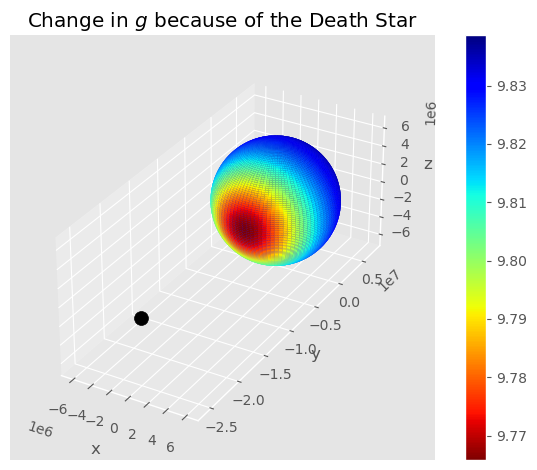

In [11]:
from matplotlib import cm
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colorbar import Colorbar
from matplotlib.ticker import LinearLocator, FormatStrFormatter

r_e = radius_SI['Earth']
d_DS = distance_SI['DS']

pos_DS = np.array([0, -d_DS, 0])

def new_g(phi, theta):
    r = x_cc(r_e, phi, theta)
    r = r.T
    # old g towards earth
    n1, n2 = np.shape(phi)[0], np.shape(phi)[1] 
    gs = np.ones((n1, n2, 3), dtype=float)
    r_norm = np.linalg.norm(r, axis=2)
    r_hat = np.copy(r)
    for i in range(np.shape(r_hat)[0]):
        for j in range(np.shape(r_hat)[1]):
            r_hat[i,j,:] = r_hat[i,j] / r_norm[i,j]

    
    g_old = g_earth * r_hat

    # connection vector to DS
    r_to_DS = np.ones_like(r, dtype=float)
    for i in range(np.shape(r)[0]):
        for j in range(np.shape(r)[1]):
            r_to_DS[i,j,:] = pos_DS - r[i,j]
    
    r_to_DS_norm = np.linalg.norm(r_to_DS, axis=2)
    r_to_DS_hat = np.copy(r_to_DS)
    for i in range(np.shape(r_to_DS_hat)[0]):
        for j in range(np.shape(r_to_DS_hat)[1]):
            r_to_DS_hat[i,j,:] = r_to_DS_hat[i,j] / r_to_DS_norm[i,j]

    g_new = np.ones_like(g_old, dtype=float)
    for i in range(np.shape(g_new)[0]):
        for j in range(np.shape(g_new)[1]):
            g_new[i,j,:] = G*mass_DS_B / r_to_DS_norm[i,j]**2 * r_to_DS_hat[i,j]

    # sum the g-vectors
    g_sum = g_old - g_new

    g_tot = np.ones((n1,n2), dtype=float)
    for i in range(n1):
        for j in range(n2):
            g_tot[i,j] = np.dot(g_sum[i,j], r_hat[i,j])
    # consider only the radial deviation since it is so small
    # use dot product with r_hat to filter out radial part
    return g_tot.T


def x_cc(r,phi,theta):
    '''
    return cartesian coordinates
    '''
    return r * np.array([np.sin(theta)*np.cos(phi),
                         np.sin(theta)*np.sin(phi),
                         np.cos(theta)])

Phi = np.linspace(0,2*np.pi,100)
Theta = np.linspace(0,np.pi,100)
Phi2D, Theta2D = np.meshgrid(Phi,Theta)

Ycomplex = np.cos(Phi2D)
Phase2D = np.angle(Ycomplex)

DensityVal = np.abs(Ycomplex)**2
DensityVal = new_g(Phi2D, Theta2D)

XYZ = x_cc(r_e, Phi2D, Theta2D)

colormap = cm.ScalarMappable( cmap=plt.get_cmap("jet_r"))
colormap.set_clim(DensityVal.min(),DensityVal.max())
colormap.set_array(DensityVal)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(XYZ[0],XYZ[1],XYZ[2],
                    facecolors = colormap.to_rgba(DensityVal),
                    rstride=1, cstride=1, linewidth=.05, shade=False)
ax.scatter(pos_DS[0], pos_DS[1], pos_DS[2], c='black', s=100)
# Set an equal aspect ratio
ax.set_aspect('equal')
ax.set_title('Change in $g$ because of the Death Star')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.colorbar(colormap, ax=ax)
# plt.savefig('change_in_g.png', dpi=300,  bbox_inches='tight')
plt.show()

In [12]:
%matplotlib widget
import matplotlib.animation as animation

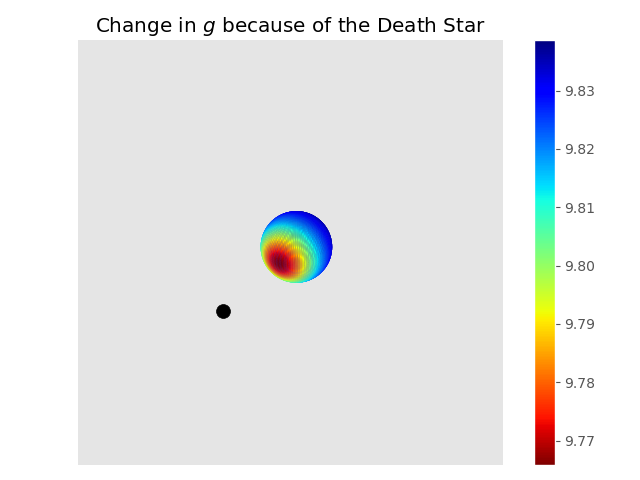

In [13]:
# make animation
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(XYZ[0],XYZ[1],XYZ[2],
                    facecolors = colormap.to_rgba(DensityVal),
                    rstride=1, cstride=1, linewidth=.05, shade=False)
ax.scatter(pos_DS[0], pos_DS[1], pos_DS[2], c='black', s=100)
# Set an equal aspect ratio
ax.set_xlim(-2.6e7, 2.6e7)
ax.set_ylim(-2.6e7, 2.6e7)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axis('off')
ax.grid(False)
ax.set_title('Change in $g$ because of the Death Star')
fig.colorbar(colormap, ax=ax)

def update(frame):
    # Calculate new viewing angles
    angle = frame * 2
    
    # Set the viewing angle
    ax.view_init(elev=10, azim=angle)
    
    return fig

# Create animation
anim = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)

In [14]:
anim.pause()

In [15]:
anim.save("g_animation.mp4", fps=30, dpi=300)

### Tidal forces

In [25]:
# estimating the tidal effects of the Death Star based on gravitational differences

d_moon = distance_SI['Moon']
d_sun = distance_SI['Earth']
d_DS = d_DS_A = d_DS_B = distance_SI['DS']
r_earth = radius_SI['Earth']

delta_g_moon = G*mass_moon * (1/(d_moon-r_earth)**2 - 1/(d_moon+r_earth)**2)
delta_g_sun = G*mass_sun * (1/(d_sun-r_earth)**2 - 1/(d_sun+r_earth)**2)
delta_g_DS_A = G*mass_DS_A * (1/(d_DS-r_earth)**2 - 1/(d_DS+r_earth)**2)
delta_g_DS_B = G*mass_DS_B * (1/(d_DS-r_earth)**2 - 1/(d_DS+r_earth)**2)

print(f'Tidal effect of the moon: {delta_g_moon:.3e}')
print(f'Tidal effect of the sun:  {delta_g_sun:.3e}')
print(f'Tidal effect of the DS_A: {delta_g_DS_A:.3e}')
print(f'Tidal effect of the DS_B: {delta_g_DS_B:.3e}')

Tidal effect of the moon: 1.873e-06
Tidal effect of the sun:  1.063e-06
Tidal effect of the DS_A: 1.245e-07
Tidal effect of the DS_B: 3.486e-02


This difference in tidal forces is enourmous for the heavy estimation of the Death Star, it exceeds the strength of the moon by four orders of magnitude. On the open sea, where we can assume average tidal ranges of about 0.2m from the moon, this would lead to huge and wide waves with heights of
\begin{equation}
h = 3.7 \text{ km}
\end{equation}
on the ocean (very simplistic model). This is as high as huge mountains, travelling over the ocean. On the coasts, where the tidal range of the Moon frequently reaches 1m or more, we must expect the heavy Death Star to increase this to incredible 18.6 km or even more. Depending on which direction the Death Star orbits Earth, those waves will come either twice or six times a day.

This model however is extremely simplistic and while we can assume that the order of magnitude of the tides, here km, is correct, we shouldn't overestimate the accuracy of the acutal values. Tides turn out to be a quite complex phenomenon, a more sophisticated model is possible in future work. For more information, see these resources:

https://austides.com/wp-content/uploads/2014/06/Kowalik_Luick_2011.pdf

https://www.youtube.com/watch?v=pwChk4S99i4&t=423s

### Visualization of Tides

In the following, we we want to produce a nice visualization of the tides using the orbit scripts we developed for objective 2. Since the tides following the Moon and the Death Star have - based on the previous calculations - completely different orders of magnitude, this will be more a symbolic visualization. But we want to achive typical animations where the satellite pulls an elliptic wave bulge over Earth's surface. 

In [4]:
import matplotlib.patches as patches

100%|████████████████████████████████████████████████████████████████████████████| 1999/1999 [00:00<00:00, 3739.24it/s]


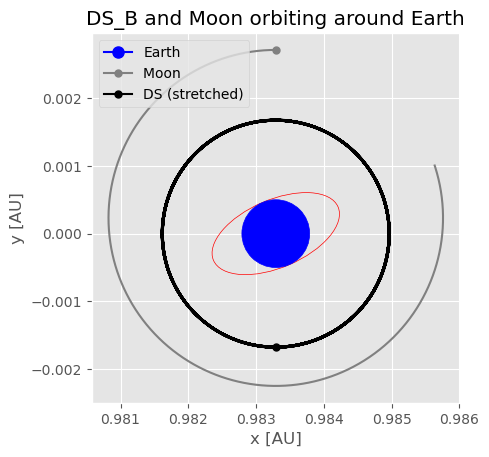

In [5]:
# This is here to make experiments

# simulate a fixed earth with moon and DS
dt=1e-2
t_max=20
sun=False
DS=True
moon=True
earth_fixed=True
moon_stretch = ''
DS_stretch = ''

time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'],
                                 sun=sun, moon=moon, DS=DS, dt=dt, t_max=t_max,
                                 earth_fixed=earth_fixed)
    
# r, moon_stretch = stretch_distance(r, 1)
r, DS_stretch = stretch_distance(r, 2, 10)

fig, ax = plt.subplots()

ax.plot(r[:,0,0], r[:,0,1], c='b')
ax.plot(r[0,0,0], r[0,0,1], marker='o', c='b', markersize=8, label='Earth')

if moon:
    ax.plot(r[:,1,0], r[:,1,1], c='grey')
    ax.plot(r[0,1,0], r[0,1,1], marker='o', c='grey', markersize=5, label=f'Moon {moon_stretch}')

if DS:
    ax.plot(r[:,2,0], r[:,2,1], c='black')
    ax.plot(r[0,2,0], r[0,2,1], marker='o', c='black', markersize=5, label=f'DS {DS_stretch}')

ax.set_title('DS_B and Moon orbiting around Earth')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.legend(loc=2)
ax.set_aspect('equal')

def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    v1_norm = np.linalg.norm(v1)
    v2_norm = np.linalg.norm(v2)
    cosine_angle = dot_product / (v1_norm * v2_norm)
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

d_earth = np.array([distance['Earth'],0])
r_earth = 0.0005 # just for drawing

def angle_for_ellipse(r):
    angle = angle_between_vectors(r-d_earth, np.array([0,1]))
    if r[0]>d_earth[0]:
        angle = 360-angle
    return angle

theta = angle_for_ellipse(r[-1,1])

# reate an ellipse patch
ellipse = patches.Ellipse(r[0,0], width=r_earth*2, height=0.002, angle=theta, edgecolor='r', facecolor='None')

# create earth
circle = plt.Circle(r[0,0], r_earth, color='b')

ax.add_patch(ellipse)
ax.add_artist(circle)

def add_ellipse(ax, theta, h_ellipse):
    ellipse = patches.Ellipse(r[0,0], width=r_earth*2, height=h_ellipse, angle=theta, 
                              edgecolor='r', facecolor='None')
    ax.add_patch(ellipse)
    return ax


# plt.savefig('earth_moon_DS_A.png', dpi=300, bbox_inches='tight')
plt.show()

Moviepy - Building video tides.mp4.
Moviepy - Writing video tides.mp4



Moviepy - Done !
Moviepy - video ready tides.mp4


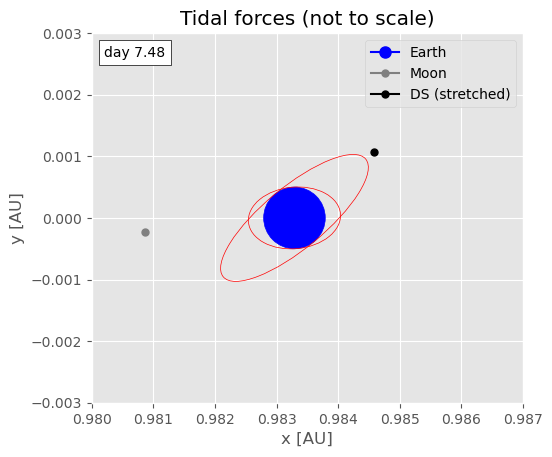

In [7]:
duration = 15
fps = 25
max_frame = int(duration*fps)

y_limits = -0.003, 0.003
x_limits = 0.98, 0.987

fig, ax = plt.subplots()

skip = 2
r = r[::skip]

def make_frame(t):
    global r, dt, x_limits, y_limits, fps, title, skip
    frame = int(t*fps)
    
    ax.clear()
    ax.set_title('Tidal forces (not to scale)')
    ax.set_xlabel("x [AU]")
    ax.set_ylabel("y [AU]")
    ax.add_artist(AnchoredText(f'day {frame*dt*skip:.2f}', loc=2))
    ax.plot(r[frame,0,0], r[frame,0,1], marker='o', c='b', markersize=8, label='Earth')
    ax.plot(r[frame,1,0], r[frame,1,1], marker='o', c='grey', markersize=5, label='Moon')
    ax.plot(r[frame,2,0], r[frame,2,1], marker='o', c='black', markersize=5, label=f'DS {DS_stretch}')

    ax.add_artist(plt.Circle(r[0,0], r_earth, color='b'))
    
    theta_moon = angle_for_ellipse(r[frame,1])
    add_ellipse(ax, theta_moon, 0.0015)

    theta_DS = angle_for_ellipse(r[frame,2])
    add_ellipse(ax, theta_DS, 0.003)
    
    ax.legend()
    ax.set_aspect('equal', 'box')
    ax.set(xlim=(x_limits), ylim=(y_limits))
    # ax.plot(0,0, marker='o', markersize=20, color='yellow')
    return mplfig_to_npimage(fig)

filename = 'tides.mp4'
animation = VideoClip(make_frame, duration=duration)
animation.write_videofile(filename, fps=fps)
mpy.ipython_display(filename, autoplay=True, loop=True)